In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
normalized_scan_100307_full = np.load(config.test_norm_data)

In [6]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [174]:
rand_sub_bval_indice_100307 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100307, 7))

In [175]:
len(rand_sub_bval_indice_100307)

112

In [176]:
bvals_100307_sub = bvals_all_100307[rand_sub_bval_indice_100307]*1e-3

In [177]:
normalized_scan_100307_sub = normalized_scan_100307_full[:, rand_sub_bval_indice_100307]

In [178]:
big_b_indice_100307_sub = np.where(bvals_100307_sub != 0.005)[0]

In [179]:
bvals_100307_sub_no_b5 = bvals_100307_sub[big_b_indice_100307_sub]

In [180]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_indice_100307_sub]

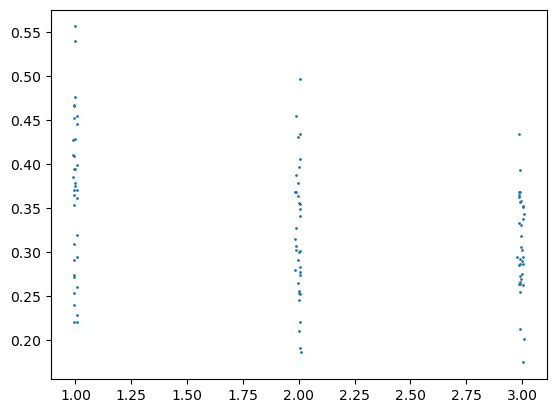

In [181]:
plt.plot(bvals_100307_sub_no_b5, normalized_scan_100307_sub_no_b5[42,:], "o", markersize = 1)

In [182]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

In [33]:
bvals_100307 = bvals_all_100307[big_b_indices_100307]*1e-3

In [40]:
normalized_scan_100307_full_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]

In [42]:
normalized_scan_100307_full_no_b5.shape

(740145, 270)

In [15]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [16]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [17]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [183]:
n_100307_all = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_100307_all[:, rand_sub_bval_indice_100307]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_indice_100307_sub].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub_no_b5 = torch.FloatTensor(bvals_100307_sub_no_b5)
gradient_directions_100307_sub_no_b5 = torch.FloatTensor(n_100307_sub_no_b5)

(105, 3)


In [192]:
net_100307 = BallStickNet(gradient_directions_100307_sub_no_b5 , b_values_100307_sub_no_b5)
net_100307.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/model_100206_7g_03.pt"))
net_100307.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=105, out_features=5, bias=True)
  )
)

In [ ]:
X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net_100307(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

In [186]:
lambda_par_100307_pred.shape

torch.Size([740145, 1])

In [187]:
X_100307_pred.shape

torch.Size([740145, 105])

In [36]:
n_100307 = n_100307_all[:,big_b_indices_100307].T
print(n_100307.shape)

(270, 3)


In [37]:
b_values_100307 = torch.FloatTensor(bvals_100307)
gradient_directions_100307 = torch.FloatTensor(n_100307)

In [38]:
net_100307_golden_std = BallStickNet(gradient_directions_100307, b_values_100307)
net_100307_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_100307_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [152]:
X_100307_pred_golden_std,theta_100307_pred_golden_std, phi_100307_pred_golden_std, mu_cart_100307_pred_golden_std, lambda_par_100307_pred_golden_std, lambda_iso_100307_pred_golden_std,  volume_0_100307_pred_golden_std, volume_1_100307_pred_golden_std = net_100307_golden_std(torch.from_numpy(normalized_scan_100307_full_no_b5.astype(np.float32)))

In [44]:
lambda_par_100307_pred_golden_std.shape

torch.Size([740145, 1])

In [47]:
type(X_100307_pred_golden_std)

torch.Tensor

In [159]:
mse_loss = torch.nn.MSELoss(reduction='mean')

In [55]:
mse_9g_1 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(mse_9g_1)

tensor(0.1010, grad_fn=<MseLossBackward0>)


In [64]:
mse_9g_2 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(mse_9g_2)

tensor(0.1019, grad_fn=<MseLossBackward0>)


In [95]:
mse_9g_3 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(mse_9g_3)

tensor(0.1048, grad_fn=<MseLossBackward0>)


In [122]:
mse_9g_4 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(mse_9g_4)

tensor(0.0978, grad_fn=<MseLossBackward0>)


In [131]:
mse_9g_5 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(mse_9g_5)

tensor(0.1033, grad_fn=<MseLossBackward0>)


In [165]:
lambda_par_mse_7g_1 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(lambda_par_mse_7g_1)

tensor(0.0828, grad_fn=<MseLossBackward0>)


In [166]:
lambda_iso_mse_7g_1 = mse_loss(lambda_iso_100307_pred_golden_std,lambda_iso_100307_pred)
print(lambda_iso_mse_7g_1)

tensor(0.6160, grad_fn=<MseLossBackward0>)


In [167]:
volume_0_mse_7g_1 = mse_loss(volume_0_100307_pred_golden_std,volume_0_100307_pred)
print(volume_0_mse_7g_1)

tensor(0.0108, grad_fn=<MseLossBackward0>)


In [168]:
volume_1_mse_7g_1 = mse_loss(volume_1_100307_pred_golden_std,volume_1_100307_pred)
print(volume_1_mse_7g_1)

tensor(0.0108, grad_fn=<MseLossBackward0>)


In [188]:
lambda_par_mse_7g_2 = mse_loss(lambda_par_100307_pred_golden_std,lambda_par_100307_pred)
print(lambda_par_mse_7g_2)

tensor(0.0644, grad_fn=<MseLossBackward0>)


In [189]:
lambda_iso_mse_7g_2 = mse_loss(lambda_iso_100307_pred_golden_std,lambda_iso_100307_pred)
print(lambda_iso_mse_7g_2)

tensor(0.3686, grad_fn=<MseLossBackward0>)


In [190]:
volume_0_mse_7g_2 = mse_loss(volume_0_100307_pred_golden_std,volume_0_100307_pred)
print(volume_0_mse_7g_2)

tensor(0.0068, grad_fn=<MseLossBackward0>)


In [191]:
volume_1_mse_7g_2 = mse_loss(volume_1_100307_pred_golden_std,volume_1_100307_pred)
print(volume_1_mse_7g_2)

tensor(0.0068, grad_fn=<MseLossBackward0>)
